<center>

# **Spam or Ham ma'am?**


##### Karla Kalajžić
</center>

<center>

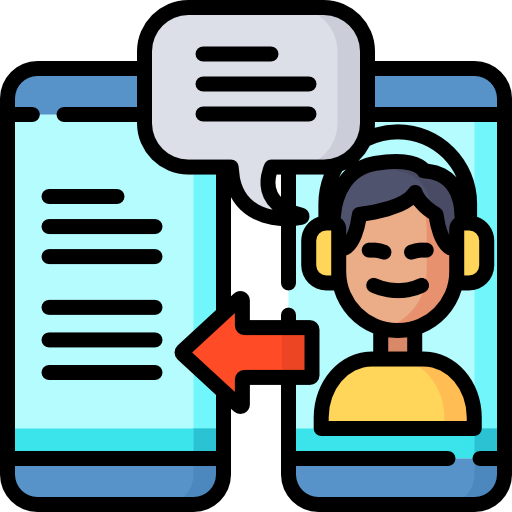

</center>

Upotreba mobilnih telefona naglo je porasla u posljednjem desetljeću što je dovelo do novog područja za reklamiranje nepotrebnih stvari od strane trgovaca. Dobro poznati Spam, je zlouporaba elektroničkih sustava za razmjenu poruka za masovno slanje neželjenih poruka. Ljudi naivno daju svoje brojeve mobilnih telefona dok koriste svakodnevne usluge, a zatim su preplavljeni neželjenim promotivnim porukama. Odnosno, SMS spam se danas koristi u velikim količinama za komercijalno oglašavanje i širenje phishing linkova.

Analogno tom, zanimljivo je bilo vidjeti provedeno istraživanje na tu temu, gdje ljudi klasificiraju neželjene SMS poruke kao dosadne (32,3%), gubljenje vremena (24,8%) i kršenje osobne privatnosti (21,3%).

Iz tog razloga, otkrivanje neželjene poruke važan je zadatak u kojem se prepoznaju i filtriraju iste.

U ovom ćemo projektu pogledati klasificiranje SMS poruka pomoću nekoliko različitih modela strojnog učenja i tako utvrditi radi li se o spam ili ham poruci te odabrati jedan algoritam na temelju najboljeg kriterija izvedbe. U nastavku prikazujem razvijeni SMS detektor neželjene pošte ili ham detektor.

Počnimo!


>**Sadržaj**

*   Import biblioteka

*   Učitavanje podataka

*   Exploratory Data Analysis
    1.   Feature Engineering
    2.   Detekcija Outliers-a


*   Data Preprocessing
    1.   Čišćenje podataka
    2.   Tokenizacija
    3.   Odbacivanje Stopwords riječi
    4.   Lematizacija
    5.   Vektorizacija

*   Model Building


*   Evaluacija modela

*   Zaključak

## **Import biblioteka**

>Učitavaju se biblioteke za potrebu projekta.

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

##**Učitavanje podataka**
> Korišten je skup podataka iz zbirke SMS neželjene pošte za izradu ham detektora. Može se preuzeti sa stranice Kaggle: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset.



Ovaj skup podataka uključuje tekst SMS poruka zajedno s oznakom koja pokazuje je li poruka neželjena ili ne. Bezvrijedne poruke označene su kao spam, dok su legitimne poruke označene kao ham.

In [ ]:
# ISO 8859-1 se odnosi na „latinicu br. 1” (sastoji se od 191 znaka latiničnog pisma)
data = pd.read_csv("spam.csv", encoding='ISO-8859-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
# Izbacivanje suvišnih stupaca
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)

In [ ]:
data.shape

(5572, 2)

In [ ]:
# Promjena naziva stupaca v1 i v2
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Dataset se sastoji od 5572 poruke na engleskom jeziku. Podaci su označeni, kao što je prethodno spomenuto, kao ham ili spam. Dataframe ima dva stupca. Prvi stupac je "Target" koji označava klasu poruke kao ham ili spam, a drugi stupac "Text" se odnosi na niz teksta unutar poruke.

##**Exploratory Data Analysis**
>Prije nego što se primijene algoritmi strojnog učenja na skup podataka, uvijek je dobra praksa vizualizirati podatke kako bismo identificirali moguće važne trendove podataka.

Prvo je prikazana distribucija ham i spam poruka u našem skupu podataka pomoću stupičastog dijagrama.

In [ ]:
# Palete boja korištene u projektu
cols= ["#2CAAC2", "#FFCA61"]

Text(0, 0.5, 'Number of Data points')

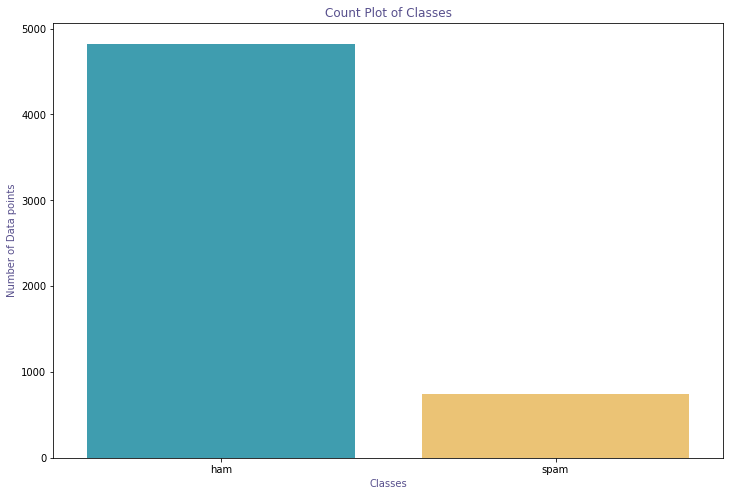

In [ ]:
# Prikaz jesu li podaci neuravnoteženi ili ne
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

Raspodjela na grafu pokazuje da je skup podataka neuravnotežen.

Nadalje, prikazan je histogram poruka s obzirom na broj riječi i za ham i za spam poruke.

In [ ]:
# Popis koji sadrži određeni broj riječi u porukama ham i njihov broj pojavljivanja u skupu podataka
dataset_ham = data[data['Target'] == "ham"]
dataset_ham_count = dataset_ham['Text'].str.split().str.len()
dataset_ham_count.index = dataset_ham_count.index.astype(str) + ' words:'
dataset_ham_count.sort_index(inplace=True)

In [ ]:
# Popis koji sadrži određeni broj riječi u porukama spam i njihov broj pojavljivanja u skupu podataka
dataset_spam = data[data['Target'] == "spam"]
dataset_spam_count = dataset_spam['Text'].str.split().str.len()
dataset_spam_count.index = dataset_spam_count.index.astype(str) + ' words:'
dataset_spam_count.sort_index(inplace=True)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


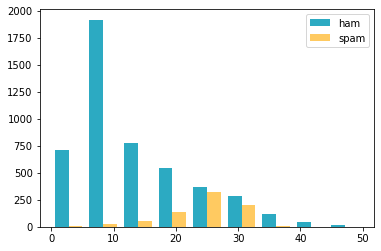

In [ ]:
# Histogram popisa spam i ham poruka
bins = np.linspace(0, 50, 10)

plt.hist([dataset_ham_count, dataset_spam_count], bins, label=['ham', 'spam'], color=cols)
plt.legend(loc='upper right')
plt.show()

Rezultat pokazuje da većina ham poruka sadrži od 0 do 10 riječi, dok je većina spam poruka duža i sadrži između 20 i 30 riječi.

### Feature Engineering

U svrhu istraživanja podataka, stvarene su nove značajke:

*   **No_of_Characters**: Broj znakova u tekstualnoj poruci

*   **No_of_Words**: Broj riječi u tekstualnoj poruci
*   **No_of_sentence**: Broj rečenica u tekstualnoj poruci

In [ ]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Dodavanje stupca s brojem znakova, riječi i rečenica za svaku poruku
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"] = data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len) # U ovom koraku riječi i rečenice su tokenizirane, ali o tome detaljnije u nastavku
data["No_of_sentence"] = data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


<Figure size 864x576 with 0 Axes>

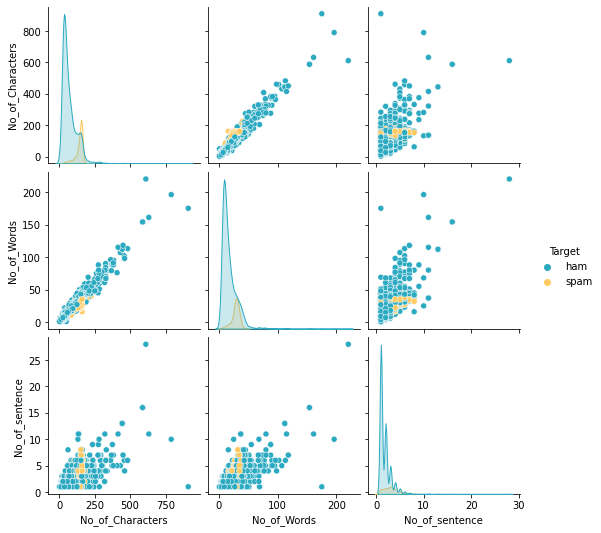

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

Iz dijagrama pair plot možemo vidjeti nekoliko outliers-a u klasi ham poruka. Ovo je zanimljivo budući da upravo te vrijednosti ujedno označavaju duljinu SMS-a.

### Detekcija Outliers-a



In [ ]:
# Odbacivanje outliers-a
data = data[(data["No_of_Characters"]<350)]
data.shape
# 24 odbačena

(5548, 5)

<Figure size 864x576 with 0 Axes>

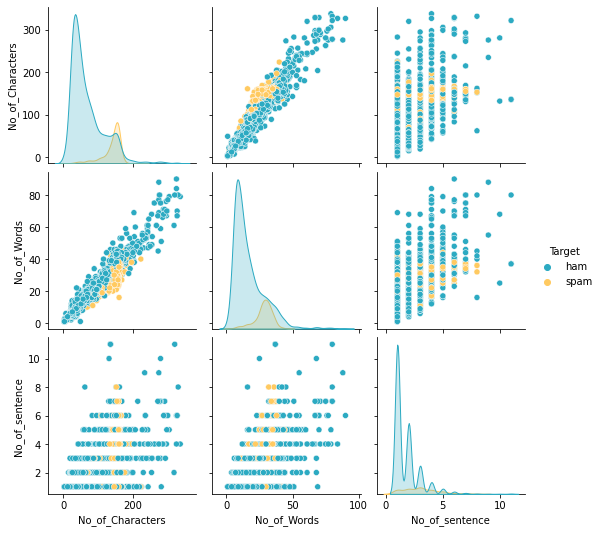

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

## **Data Preprocessing**
>Tekstualni podaci mogu sadržavati znakove i znamenke. Većinu vremena ti znakovi zapravo ne igraju nikakvu ulogu u klasifikaciji. Ovisno o poznavanju domene, ponekad je dobro očistiti tekst uklanjanjem istih.



### Čišćenje podataka

Proces **čišćenja podataka** je ključan. Računalo ne razumije tekst, već ima samo dojam skupa simbola. Za daljnju obradu podataka trebalo ih se učiniti čišćima.

U prvom koraku izdvajamo samo abecedne znakove, tako da uklanjamo interpunkcijske znakove i brojeve. Dalje sve znakove pretvaramo u mala slova.

Konačni tekst će se zatim koristiti u daljnjoj obradi.

In [ ]:
# Uzorak teksta prije čišćenja
print("\033[1m\u001b[44;1m Prvih 5 poruka :\033[0m",*data["Text"][:5], sep = "\n")

 Prvih 5 poruka :
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [ ]:
# Definiranje funkcije za čišćenje teksta
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) # Zamjena svih neabecednih znakova razmakom
    sms = sms.lower() # Pretvaranje u mala slova
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)

In [ ]:
# Uzorak teksta nakon čišćenja
print("\033[1m\u001b[44;1m Prvih 5 poruka nakon čišćenja :\033[0m",*data["Clean_Text"][:5], sep = "\n")

 Prvih 5 poruka nakon čišćenja :
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


### Tokenizacija
>**Tokenizacija** je razbijanje složenih podataka u manje jedinice koje se nazivaju tokeni. To se može učiniti dijeljenjem odlomaka u rečenice i rečenica u riječi.

U ovom koraku podijelio se prethodno pročišćen Clean_Text na riječi.

In [ ]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[44;1m Prvih 5 poruka nakon Tokenizacije :\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 Prvih 5 poruka nakon Tokenizacije :
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


### Odbacivanje Stopwords riječi
>**Stopwords** riječi su riječi koje se često pojavljuju (kao npr. nekoliko, je, itd.). Ove riječi imaju značenje u strukturi rečenice, ali ne pridonose mnogo u obradi podataka.

U svrhu uklanjanja suvišnosti u obradi ovih podataka, iste uklanjamo. Biblioteka NLTK ima skup zadanih Stopwords riječi koje se uklanjaju.

In [ ]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Funkcija za uklanjanje Stopwords riječi
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

In [ ]:
print("\033[1m\u001b[44;1m Prvih 5 poruka nakon odbacivanja Stopwords riječi :\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 Prvih 5 poruka nakon odbacivanja Stopwords riječi :
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


### Lematizacija
>**Lematizacija** pretvara riječ u njen korijenski oblik.
Osnova riječi nastaje uklanjanjem prefiksa ili sufiksa riječi.


Tim se osigurava da korijen riječi pripada jeziku kojim se bavimo, u ovom slučaju to je engleski. Ako koristimo lematizaciju, izlaz će biti na engleskom.

In [ ]:
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)

In [ ]:
print("\033[1m\u001b[44;1m Prvih 5 poruka nakon Lemmatizacije :\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 Prvih 5 poruka nakon Lemmatizacije :
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


###Vektorizacija
>Vektorizacija riječi - U NLP-u pročišćene podatke potrebno je pretvoriti u numerički format gdje je svaka riječ predstavljena matricom.

Koraci kroz vektorizaciju:


*   Stvaranje korpusa lematiziranog teksta

*   Pretvaranje korpusa u vektorski oblik
*   Encoding klasa u 'Target' stupcu

In [ ]:
# Stvaranje korpusa tekstualnih značajki za daljnje kodiranje u vektorizirani oblik
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]
print("\033[1m\u001b[44;1m Prvih 5 poruka u korpusu :\033[0m",*corpus[:5], sep = "\n")

 Prvih 5 poruka u korpusu :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [ ]:
# Promjena tekstualnih podataka u brojeve
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

In [ ]:
# Tip podataka nakon vektorizacije
X.dtype

dtype('float64')

In [ ]:
# Oznaka kodira 'Target' i koristi ga kao y varijablu
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

## **Model Building**
>Korištena su četiri različita klasifikatora kako bi pronašli onaj koji najbolje odgovara modelu koji traži poboljšanje rezultata. Na kraju, rezultat točnosti nam govori koliko dobro naš model funkcionira.

Koraci uključeni u izradu modela:

*   Postavljanje značajki i targeta kao X i y

*   Podjela testnih i trening skupova podataka

*   Izrada modela za četiri različita klasifikatora:

 1.   Naive Bayes

 2.   Random Forest Classifier
 3.   KNighbors Classifier

 4.   Support Vector Machines


*   Fittat sve modele nad podacima za obuku


*   Cross-validation provjera i usporedba točnosti na setu za treniranje za sve modele

In [ ]:
# Postavljanje vrijednosti za oznake y i X (X već određen u vektorizaciji)
y = data["Target"]
# Splitting na test and train skupove podataka
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Testiranje na sljedećim klasifikatorima
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Rječnik vrste modela radi lakšeg snalaženja
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [ ]:
# Cross-validation
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
RandomForest: 0.974762 
KNeighbours: 0.911450 
SVC: 0.974086 


##**Evaluacija modela**
>**Evaluacija algoritma** uključuje usporedbu stvarnih izlaza u testnom skupu s izlazima koje predviđa algoritam.


Testiranje modela na Testsetu:


*   Accuracy Report
*   Confusion Matrix

In [ ]:
# Model Evaluation
# Stvaranje popisa raznih rezultata
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)

    #Dodavanje rezultata
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [ ]:
# Inicijalizacija podataka s popisa
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}

# Kreiranje pandas DateFrame-a
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [ ]:
cmap2 = ListedColormap(["#2CAAC2","#FFCA61"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.816176,0.898785,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


1. kv. TP (True Positive)- Predicted positive and it’s true.

2. kv. FP (False Positive)- Predicted positive and it’s false.

3. kv. FN (False Negative)- Predicted negative and it’s false.

4. kv. TN (True Negative)- Predicted negative and it’s true.

(Predviđene vrijednosti su pozitivne i negativne, a stvarne vrijednosti kao istinite i lažne)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

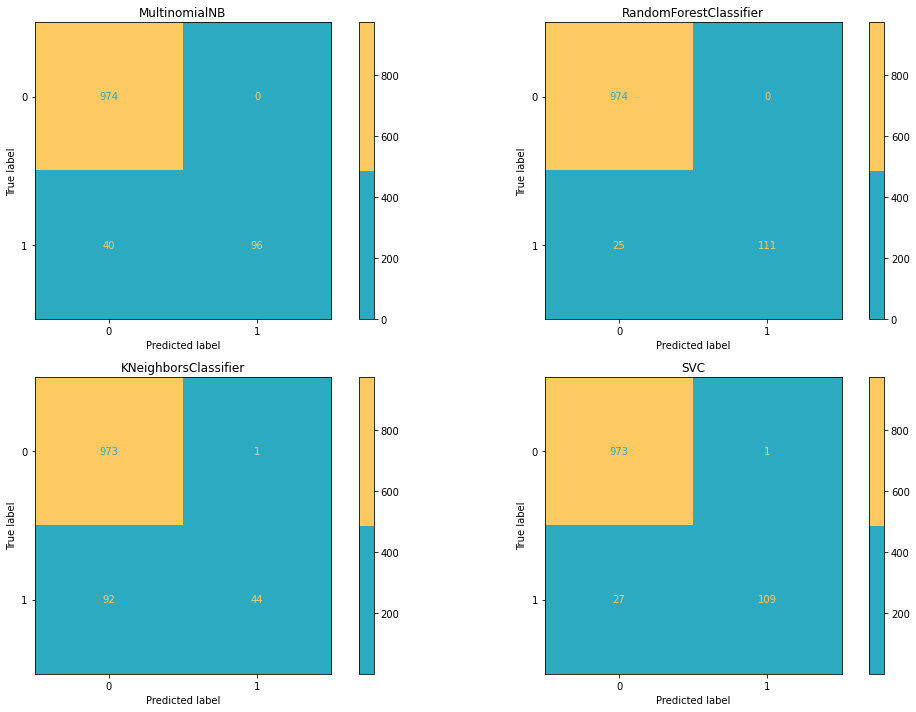

In [ ]:
cmap = ListedColormap(["#2CAAC2", "#FFCA61"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls,
                          X_test,
                          y_test,
                          ax=ax,
                          cmap= cmap,
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

## **Zaključak**

Uspješno je kreiran i implementiran model strojnog učenja koristeći četiri različita algoritma za klasifikaciju. Utvrđeno je da u našem slučaju algoritam Random Forest radi nešto bolje od ostala tri algoritma.

Među svim modelima strojnog učenja, Random Forest klasifikator pokazuje dobru točnost od 97.47%. Ostali pokazuju točnost od oko 91% do 97%, što je isto jako dobro. Moramo naravno uzeti u obzir da je negdje moglo doći do overfittanih podataka.

Prema recall parametru koji nam govori koliko smo od pozitivno predviđenih vrijednosti točno predvidili vrijednosti, vidimo da je Random Forest na vrhu od približno 89.9%. Precision parametrom primjećujemo da Naive Bayes i Random Forest algoritmi imaju od svih pozitivno predviđenih vrijednosti, uistinu 100% pozitivne vrijednosti. Za Naive Bayes je to očekivano, jer znamo da ga je najbolje koristiti u obradi teksta (provjerava vjerojatnost pojavljivanja svake riječi). F1 score uzima u obzir stupce Precision i Recall, te tim potvrđujemo da Random Forest ima najbolji postotak od 89.9%. S druge strane vidimo dosta lošije rezultate KNeighbours algoritma.

Konačno, za izradu ham detektor odabrala bih Random Forest algoritam.
